# **AudioFuse**

This notebook contains the end-to-end implementation of our proposed **AudioFuse** and also its baseline models for comparision on PASCAL dataset. We used the PhysioNet 2016 Challenge dataset (Heart Sound Classification/Abnormality Detection) to pretrain our model. Now, we test the generalizability of this model using the PASCAL dataset.

## **Imports**

In [ ]:
# ================================================================
# Block 1: Imports
# ================================================================
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import shutil
import math

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Metrics & Utilities
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, matthews_corrcoef,
    cohen_kappa_score, roc_auc_score, roc_curve
)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling mixed precision for a significant speed boost
mixed_precision.set_global_policy('mixed_float16')

# Ensuring reproducible results
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## **Configuration**

In [ ]:
# ================================================================
# Block 2: Configuration for PASCAL Experiment
# ================================================================
class Config:
    # --- PASCAL Dataset Paths ---
    DRIVE_FOLDER = "/content/drive/MyDrive/Multimodal Audio Fusion"
    ORIGINAL_ZIP_PATH = os.path.join(DRIVE_FOLDER, "Pascal Heart Sounds.zip")

    # --- Image/Input Settings ---
    IMG_SIZE = 224
    IN_CHANS = 1
    WAVEFORM_LENGTH_SECONDS = 5 # Identical to PhysioNet for consistency
    SAMPLE_RATE = 22050
    SIGNAL_LENGTH_SECONDS = 5 # Identical to PhysioNet for consistency
    N_MELS = 224
    N_FFT = 2048
    HOP_LENGTH = 512
    WAVELET = 'morl'
    IMG_SIZE = 224

    # --- Custom ViT Model Settings ---
    PATCH_SIZE = 16
    PROJECTION_DIM = 192
    NUM_HEADS = 8
    TRANSFORMER_LAYERS = 6
    MLP_UNITS = [int(PROJECTION_DIM * 2), PROJECTION_DIM]
    DROPOUT_RATE = 0.2

    # --- Training Settings ---
    BATCH_SIZE = 128
    EPOCHS = 100
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4

    # --- Data Split Settings ---
    TEST_SPLIT_RATIO = 0.2
    RANDOM_STATE = 42

CONFIG = Config()
WAVEFORM_MAX_LEN = int(CONFIG.WAVEFORM_LENGTH_SECONDS * 22050) # 22.05kHz sample rate

## **Data Loading & Splitting**

In [ ]:
# ================================================================
# Block: Data Setup for PASCAL (Set B Only, Patient-Aware Split)
# ================================================================

import os
import zipfile
import glob
import pandas as pd
import numpy as np
import shutil

# --- 1. Defining Paths ---
DRIVE_FOLDER = "/content/drive/MyDrive/Multimodal Audio Fusion"
PROCESSED_ZIP_PATH = os.path.join(DRIVE_FOLDER, "PASCAL_processed_binary_test.zip")
ORIGINAL_ZIP_PATH = os.path.join(DRIVE_FOLDER, "Pascal Heart Sounds.zip")
METADATA_CSV = os.path.join(DRIVE_FOLDER, "pascal_metadata_binary_test.csv")

# --- 2. Unzipping All Necessary Data ---
print("Unzipping data...")
LOCAL_PROCESSED_ROOT = "/content/PASCAL_processed/"
LOCAL_ORIGINAL_ROOT = "/content/PASCAL_extracted/"
if os.path.exists(LOCAL_PROCESSED_ROOT): shutil.rmtree(LOCAL_PROCESSED_ROOT)
if os.path.exists(LOCAL_ORIGINAL_ROOT): shutil.rmtree(LOCAL_ORIGINAL_ROOT)
with zipfile.ZipFile(PROCESSED_ZIP_PATH, 'r') as zf: zf.extractall(LOCAL_PROCESSED_ROOT)
with zipfile.ZipFile(ORIGINAL_ZIP_PATH, 'r') as zf: zf.extractall(LOCAL_ORIGINAL_ROOT)

# --- 3. Loading Metadata and Filtering for Set B ---
print("\nLoading metadata and filtering for Set B...")
full_df = pd.read_csv(METADATA_CSV)
set_b_df = full_df[full_df['filepath'].str.contains('/set_b/', na=False)].copy()
print(f"Filtered down to {len(set_b_df)} samples from Set B.")

# --- 4. Extracting Patient IDs ---
def get_patient_id_from_set_b(filepath):
    """
    Robustly extracts the numeric patient ID from a Set B filename,
    handling edge cases like 'normal_noisynormal_...'.
    """
    basename = os.path.basename(str(filepath))
    # Removing file extension and splitting by underscore
    parts = os.path.splitext(basename)[0].split('_')
    # Finding the first part that is a number
    for part in parts:
        if part.isdigit():
            return part
    return None # Return None if no numeric ID is found

set_b_df['patient_id'] = set_b_df['filepath'].apply(get_patient_id_from_set_b)
# Removing any rows where a patient ID could not be parsed
set_b_df.dropna(subset=['patient_id'], inplace=True)

# --- 5. Performing Patient-Aware 80/20 Split ---
unique_patients = sorted(set_b_df['patient_id'].unique())
print(f"Found {len(unique_patients)} unique patients in Set B for splitting.")

np.random.seed(CONFIG.RANDOM_STATE)
np.random.shuffle(unique_patients)
split_index = int(len(unique_patients) * (1 - CONFIG.TEST_SPLIT_RATIO))
train_subjects = set(unique_patients[:split_index])
val_subjects = set(unique_patients[split_index:])
print(f"Splitting into {len(train_subjects)} training patients and {len(val_subjects)} validation patients.")

# Creating the final DataFrames by filtering the Set B data
train_df = set_b_df[set_b_df['patient_id'].isin(train_subjects)].copy()
val_df = set_b_df[set_b_df['patient_id'].isin(val_subjects)].copy()

# --- 6. Correcting the File Paths for the Current Runtime ---
print("\nCorrecting file paths in metadata...")
def find_file(root_dir, filename):
    """Robustly find a file in a directory, even if nested."""
    matches = glob.glob(os.path.join(root_dir, f"**/{filename}"), recursive=True)
    return matches[0] if matches else None

train_df['npy_filepath'] = train_df['npy_filepath'].apply(lambda f: find_file(LOCAL_PROCESSED_ROOT, os.path.basename(f)))
train_df['filepath'] = train_df['filepath'].apply(lambda f: find_file(LOCAL_ORIGINAL_ROOT, os.path.basename(f)))
val_df['npy_filepath'] = val_df['npy_filepath'].apply(lambda f: find_file(LOCAL_PROCESSED_ROOT, os.path.basename(f)))
val_df['filepath'] = val_df['filepath'].apply(lambda f: find_file(LOCAL_ORIGINAL_ROOT, os.path.basename(f)))

# Dropping any rows where a file might have been missing after the search
train_df.dropna(subset=['npy_filepath', 'filepath'], inplace=True)
val_df.dropna(subset=['npy_filepath', 'filepath'], inplace=True)

# --- 7. Final Check ---
assert set(train_df['patient_id']).isdisjoint(set(val_df['patient_id'])), "FATAL ERROR: Data leakage detected!"
print("\nValidation successful: No patient overlap detected.")
assert os.path.exists(train_df.iloc[0]['filepath']), f"WAV file not found at corrected path: {train_df.iloc[0]['filepath']}"
assert os.path.exists(train_df.iloc[0]['npy_filepath']), f"NPY file not found at corrected path: {train_df.iloc[0]['npy_filepath']}"
print("File paths successfully corrected and validated.")

NUM_CLASSES = train_df['label'].nunique()
CLASS_NAMES = ['Normal', 'Abnormal']
print(f"\nTraining set size: {len(train_df)} files from {train_df['patient_id'].nunique()} subjects.")
print(f"Validation set size: {len(val_df)} files from {val_df['patient_id'].nunique()} subjects.")

Unzipping data...

Loading metadata and filtering for Set B...
Filtered down to 461 samples from Set B.
Found 165 unique patients in Set B for splitting.
Splitting into 132 training patients and 33 validation patients.

Correcting file paths in metadata...

Validation successful: No patient overlap detected.
File paths successfully corrected and validated.

Training set size: 373 files from 132 subjects.
Validation set size: 88 files from 33 subjects.


## **Fast Data Pipeline**

In [ ]:
# ================================================================
# Block 4: On-the-Fly Data Pipeline (Spectrogram + Waveform)
# ================================================================
import librosa

def load_spec_and_waveform_on_the_fly(filepath, label):
    def _py_load_and_process(path):
        import numpy as np
        import cv2
        path_str = path.numpy().decode('utf-8')
        wav, _ = librosa.load(path_str, sr=22050, mono=True)
        if len(wav) > WAVEFORM_MAX_LEN: wav = wav[:WAVEFORM_MAX_LEN]
        else: wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')

        mel_spec = librosa.feature.melspectrogram(y=wav, sr=22050, n_fft=CONFIG.N_FFT, hop_length=512, n_mels=CONFIG.IMG_SIZE)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        spec_resized = cv2.resize(log_mel_spec, (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))
        spec_norm = (spec_resized - spec_resized.min()) / (spec_resized.max() - spec_resized.min() + 1e-6)

        return spec_norm.astype(np.float32), wav.astype(np.float32)

    [spectrogram, waveform] = tf.py_function(_py_load_and_process, [filepath], [tf.float32, tf.float32])

    spectrogram.set_shape([CONFIG.IMG_SIZE, CONFIG.IMG_SIZE])
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    waveform.set_shape([WAVEFORM_MAX_LEN])
    label.set_shape([])

    return {"spec_input": spectrogram, "wave_input": waveform}, label

def create_hybrid_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    dataset = dataset.map(load_spec_and_waveform_on_the_fly, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle: ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_hybrid_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_hybrid_dataset(val_df))
print("\nOn-the-fly hybrid data pipeline is ready.")


On-the-fly hybrid data pipeline is ready.


In [ ]:
# ================================================================
# Calculating Class Weights to Handle Imbalance
# ================================================================
from sklearn.utils import class_weight

train_labels = train_df['label'].values

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("Calculated Class Weights:")
print(class_weight_dict)

Calculated Class Weights:
{0: np.float64(0.6985018726591761), 1: np.float64(1.759433962264151)}


## **Model Building**

In [ ]:
# ================================================================
# Block 5: Model Building (Spectrogram-Waveform Fusion)
# ================================================================

@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

# --- Hybrid Fusion Model ---
def create_spec_wave_fusion_vit(num_classes):
    # --- 1. Defining Two Separate Inputs ---
    spec_input = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spec_input")
    wave_input = layers.Input(shape=(WAVEFORM_MAX_LEN,), name="wave_input")

    # ================================================================
    # Branch 1: The Custom 2D Vision Transformer
    # ================================================================
    print("Building Spectrogram ViT Branch...")
    spec_patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM, name="spec_patch_embed")(spec_input)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    spec_pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM, name="spec_pos_embedding")
    positions = tf.range(start=0, limit=num_patches, delta=1)
    spec_encoded = spec_patch_embed + spec_pos_embedding(positions)
    for i in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
        attn = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)(x1, x1)
        x2 = layers.Add()([attn, spec_encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE + 0.1)(x3)
        spec_encoded = layers.Add()([x3, x2])
    spec_representation = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
    spec_features = layers.GlobalAveragePooling1D(name="spec_gap")(spec_representation)

    # ================================================================
    # Branch 2: The 1D Waveform CNN
    # ================================================================
    print("Building Waveform CNN Branch...")
    # Reshaping waveform to add a "channels" dimension for Conv1D
    wave_reshaped = layers.Reshape((-1, 1))(wave_input)

    x_1d = layers.Conv1D(64, kernel_size=16, strides=4, activation='relu', padding='same')(wave_reshaped)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(128, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(256, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)

    wave_pooled = layers.GlobalAveragePooling1D()(x_1d)

    # A dense layer to summarize the waveform info into a small, powerful vector
    wave_features = layers.Dense(64, activation='relu', name="waveform_funnel")(wave_pooled)

    # ================================================================
    # 3. Late Fusion and Final Classifier
    # ================================================================
    print("Building Fusion Head...")
    fused_features = layers.Concatenate(axis=-1, name="fusion_concat")([spec_features, wave_features])

    x = layers.Dense(CONFIG.PROJECTION_DIM, activation='relu', name="fusion_dense_1")(fused_features)
    x = layers.Dropout(0.5)(x) # Using a higher dropout in the head

    if num_classes == 2:
        output_activation, output_units = None, 1
    else:
        output_activation, output_units = "softmax", num_classes

    outputs = layers.Dense(output_units, activation=output_activation, dtype='float32', name="predictions")(x)

    model = keras.Model(inputs=[spec_input, wave_input], outputs=outputs)
    return model

# --- Instantiating the new model ---
NUM_CLASSES = train_df['label'].nunique()
model = create_spec_wave_fusion_vit(num_classes=NUM_CLASSES)
model.summary()

Building Spectrogram ViT Branch...
Building Waveform CNN Branch...
Building Fusion Head...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spec_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_patch_embed    │ (None, 196, 192)  │     49,344 │ spec_input[0][0]  │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 196, 192)  │          0 │ spec_patch_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 196, 288)  │     55,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 196, 288)  │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 196, 192)  │     55,488 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 196, 192)  │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 196, 192)  │          0 │ dropout_54[0][0], │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 196, 288)  │     55,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 196, 288)  │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 1,814,593 (6.92 MB)

 Trainable params: 1,813,697 (6.92 MB)

 Non-trainable params: 896 (3.50 KB)

# **PhysioNet Trained Initialization**

In [ ]:
# ================================================================
# Block 5: Model Building and Transfer Learning
# ================================================================

# --- Step 1: Defining the Fusion Model Architecture ---

@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

def create_spec_wave_fusion_vit(num_classes):
    spec_input = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spec_input")
    wave_input = layers.Input(shape=(WAVEFORM_MAX_LEN,), name="wave_input")

    # Custom Spectrogram ViT Branch
    spec_patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM, name="spec_patch_embed")(spec_input)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    spec_pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM, name="spec_pos_embedding")
    positions = tf.range(start=0, limit=num_patches, delta=1)
    spec_encoded = spec_patch_embed + spec_pos_embedding(positions)
    for i in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
        attn = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)(x1, x1)
        x2 = layers.Add()([attn, spec_encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)
        spec_encoded = layers.Add()([x3, x2])
    spec_representation = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
    spec_features = layers.GlobalAveragePooling1D(name="spec_gap")(spec_representation)

    # Waveform CNN Branch
    wave_reshaped = layers.Reshape((-1, 1))(wave_input)
    x_1d = layers.Conv1D(64, kernel_size=16, strides=4, activation='relu', padding='same')(wave_reshaped)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)
    x_1d = layers.Conv1D(128, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)
    x_1d = layers.Conv1D(256, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    wave_pooled = layers.GlobalAveragePooling1D()(x_1d)
    wave_features = layers.Dense(64, activation='relu', name="waveform_funnel")(wave_pooled)

    # Late Fusion and Final Classifier
    fused_features = layers.Concatenate(axis=-1, name="fusion_concat")([spec_features, wave_features])
    x = layers.Dense(CONFIG.PROJECTION_DIM, activation='relu', name="fusion_dense_1")(fused_features)
    x = layers.Dropout(0.5, name="dropout_final")(x)
    outputs = layers.Dense(1, activation=None, dtype='float32', name="predictions")(x)

    model = keras.Model(inputs=[spec_input, wave_input], outputs=outputs)
    return model

# --- Step 2: Instantiating a New Model for the PASCAL Task ---
print("Creating a new model instance for PASCAL training...")
pascal_model = create_spec_wave_fusion_vit(num_classes=2)

# --- Step 3: Loading the Fully Trained PhysioNet Model ---
PHYSIO_MODEL_PATH = "/content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_spec_wave_fusion.keras"
print(f"Loading pre-trained weights from: {PHYSIO_MODEL_PATH}")
physionet_model = keras.models.load_model(PHYSIO_MODEL_PATH, custom_objects={'PatchEmbed': PatchEmbed})

# --- Step 4: Transferring the Weights ---
pascal_model.set_weights(physionet_model.get_weights())
print("SUCCESS: Weights have been transferred from the PhysioNet model to the new PASCAL model.")

# We will use this `pascal_model` in the next training block
model = pascal_model

Creating a new model instance for PASCAL training...
Loading pre-trained weights from: /content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_spec_wave_fusion.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


SUCCESS: Weights have been transferred from the PhysioNet model to the new PASCAL model.


## **Model Building**

In [ ]:
# Class Weighting

# --- Automatic calculation ---
# class_weights = class_weight.compute_class_weight('balanced', ...)
# class_weight_dict = dict(enumerate(class_weights))

# --- Manual Weight Assignment ---
num_normals = train_df['label'].value_counts()[0]
num_abnormals = train_df['label'].value_counts()[1]

# We tried a weight of 2 for the abnormal class instead of a very high number.
manual_weight_for_abnormal = 2

class_weight_dict = {
    0: 1.0,  # The weight for the 'Normal' class is set to 1.
    1: manual_weight_for_abnormal # Manual weight for the 'Abnormal' class
}

print("Using MANUAL Class Weights:")
print(class_weight_dict)

Using MANUAL Class Weights:
{0: 1.0, 1: 2}


In [ ]:
# =========================================================================
# Block: Model Training (Only last few dense layers to be fine-tuned)
# =========================================================================

# --- 1. Freezing the Backbone Layers ---
print("\n--- Preparing for Feature Extraction ---")
# Freezing all layers in the model initially
for layer in model.layers:
    layer.trainable = False

# Selectively unfreezing only the final head layers that need to be re-trained.
head_layer_names = ["fusion_dense_1", "predictions", "waveform_funnel"]

# Also unfreezing the final dropout layer
for layer in model.layers:
    if "dropout" in layer.name:
        head_layer_names.append(layer.name)

for layer_name in head_layer_names:
    try:
        model.get_layer(name=layer_name).trainable = True
    except ValueError:
        print(f"Warning: Layer '{layer_name}' not found, skipping.")

# --- 2. Compiling the Model ---
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy', keras.metrics.AUC(name="auc")]
)
print("\nModel compiled for training the head only:")
model.summary()

# --- 3. Defining Callbacks ---
checkpoint_filepath = "best_model_pascal_head_trained.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_auc',
    mode='max',
    save_best_only=True
)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=40,
    restore_best_weights=True
)

# --- 4. Training the Model ---
print("\nStarting model training (head only)...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    steps_per_epoch=math.ceil(len(train_df) / CONFIG.BATCH_SIZE),
    validation_data=val_ds,
    validation_steps=math.ceil(len(val_df) / CONFIG.BATCH_SIZE),
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight_dict
)
print("Training complete.")


--- Preparing for Feature Extraction ---

Model compiled for training the head only:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spec_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_patch_embed    │ (None, 196, 192)  │     49,344 │ spec_input[0][0]  │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 196, 192)  │          0 │ spec_patch_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_41[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_42[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_106         │ (None, 196, 384)  │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 196, 192)  │     73,920 │ dropout_106[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_107         │ (None, 196, 192)  │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_43 (Add)        │ (None, 196, 192)  │          0 │ dropout_107[0][0… │
│                     │                   │            │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_43[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_43[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_44[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_109         │ (None, 196, 384)  │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 2,556,481 (9.75 MB)

 Trainable params: 65,985 (257.75 KB)

 Non-trainable params: 2,490,496 (9.50 MB)


Starting model training (head only)...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.7142 - auc: 0.5211 - loss: 0.8947 - val_accuracy: 0.6016 - val_auc: 0.5000 - val_loss: 0.6660
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.6771 - auc: 0.4928 - loss: 0.9172 - val_accuracy: 0.6016 - val_auc: 0.7434 - val_loss: 0.6913
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6742 - auc: 0.4962 - loss: 0.9139 - val_accuracy: 0.6016 - val_auc: 0.7347 - val_loss: 0.6861
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.7122 - auc: 0.5770 - loss: 0.8738 - val_accuracy: 0.6016 - val_auc: 0.7165 - val_loss: 0.6672
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.6846 - auc: 0.5154 - loss: 0.8987 - val_accuracy: 0.6016 - val_auc: 0.6984 - val_loss: 0.6677
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.7087 - auc: 0.5476 - loss: 0.8541 - val_accuracy: 0.6016 - val_auc: 0.6903 - val_loss: 0.6726
Epoch 7/100
3/3 ━━━

## **Evaluation**


Loading model for final evaluation from: /content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PASCAL Heart Sounds/best_model_pascal_head_trained_High AUC.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 118 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 114 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Extracting true labels...

Skipping training history plot (no history object available).

Calculating key performance metrics...
Matthews Correlation Coefficient: 0.4519
Cohen's Kappa Score: 0.4518
AUC-ROC Score: 0.7181

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7778    0.7925    0.7850        53
    Abnormal     0.6765    0.6571    0.6667        35

    accuracy                         0.7386        88
   macro avg     0.7271    0.7248    0.7259        88
weighted avg     0.7375    0.7386    0.7380        88


Plotting Confusion Matrix...


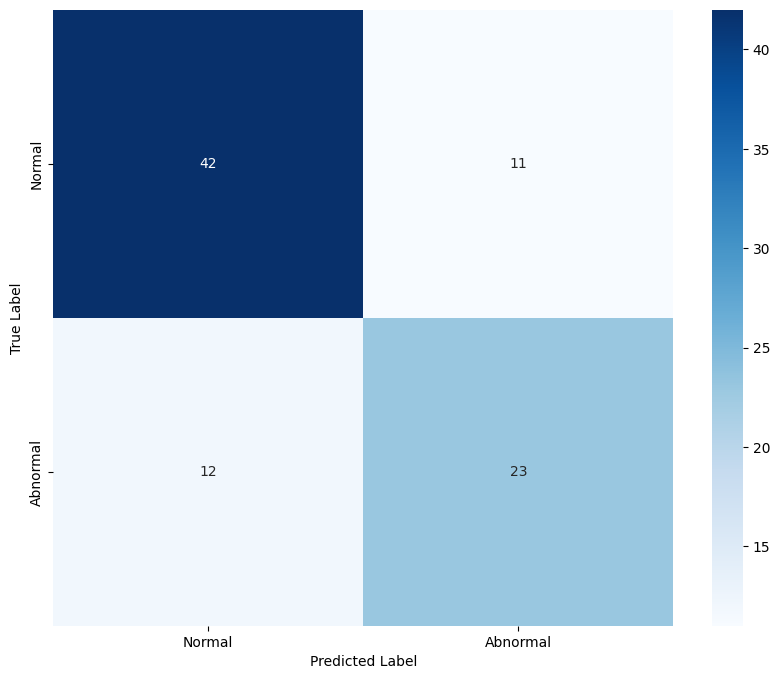


Plotting ROC Curves...


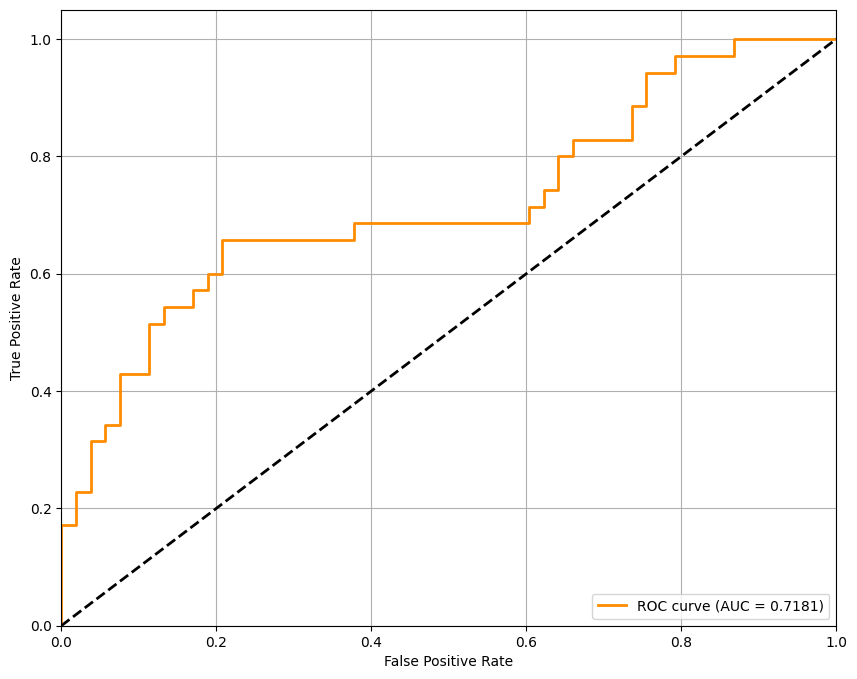

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed}
)

# --- Creating a finite dataset for evaluation ---
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_hybrid_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions on the finite validation set ---
print("Generating predictions on the validation set...")
predictions = best_model.predict(val_ds_eval)

# --- Getting true labels directly from the DataFrame ---
print("Extracting true labels...")
y_true = val_df['label'].values

# --- Processing predictions based on the task ---
if NUM_CLASSES == 2:
    # For binary classification, applying sigmoid to get probabilities
    y_prob = tf.nn.sigmoid(predictions).numpy().flatten()
    y_pred = (y_prob > 0.549).astype(int)
else:
    # For multi-class, softmax already gives probabilities
    y_prob = predictions
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")

# --- Matthews Correlation Coefficient and Cohen's Kappa ---
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

# --- AUC-ROC Scores ---
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    # Using One-vs-Rest for multi-class AUC
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    auc_roc_weighted = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")
    print(f"AUC-ROC (Weighted Average): {auc_roc_weighted:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
try:
    class_names = [name for name, index in sorted(class_to_id.items(), key=lambda item: item[1])]
except NameError:
    class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    # Binarizing the labels for multi-class ROC
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc:.4f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XAI & Attention Rollout**

Setting up Explainable AI components for the Hybrid Model...
Loading best trained model from: best_model_pascal_head_trained.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 118 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 114 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Copying weights from trained model to ViT explainer model...
ViT explainer model is ready.
Waveform CNN explainer will use layer: conv1d_11


------------------------------------------------------------
Explaining Sample 1: True Label = 0, Predicted Label = 1


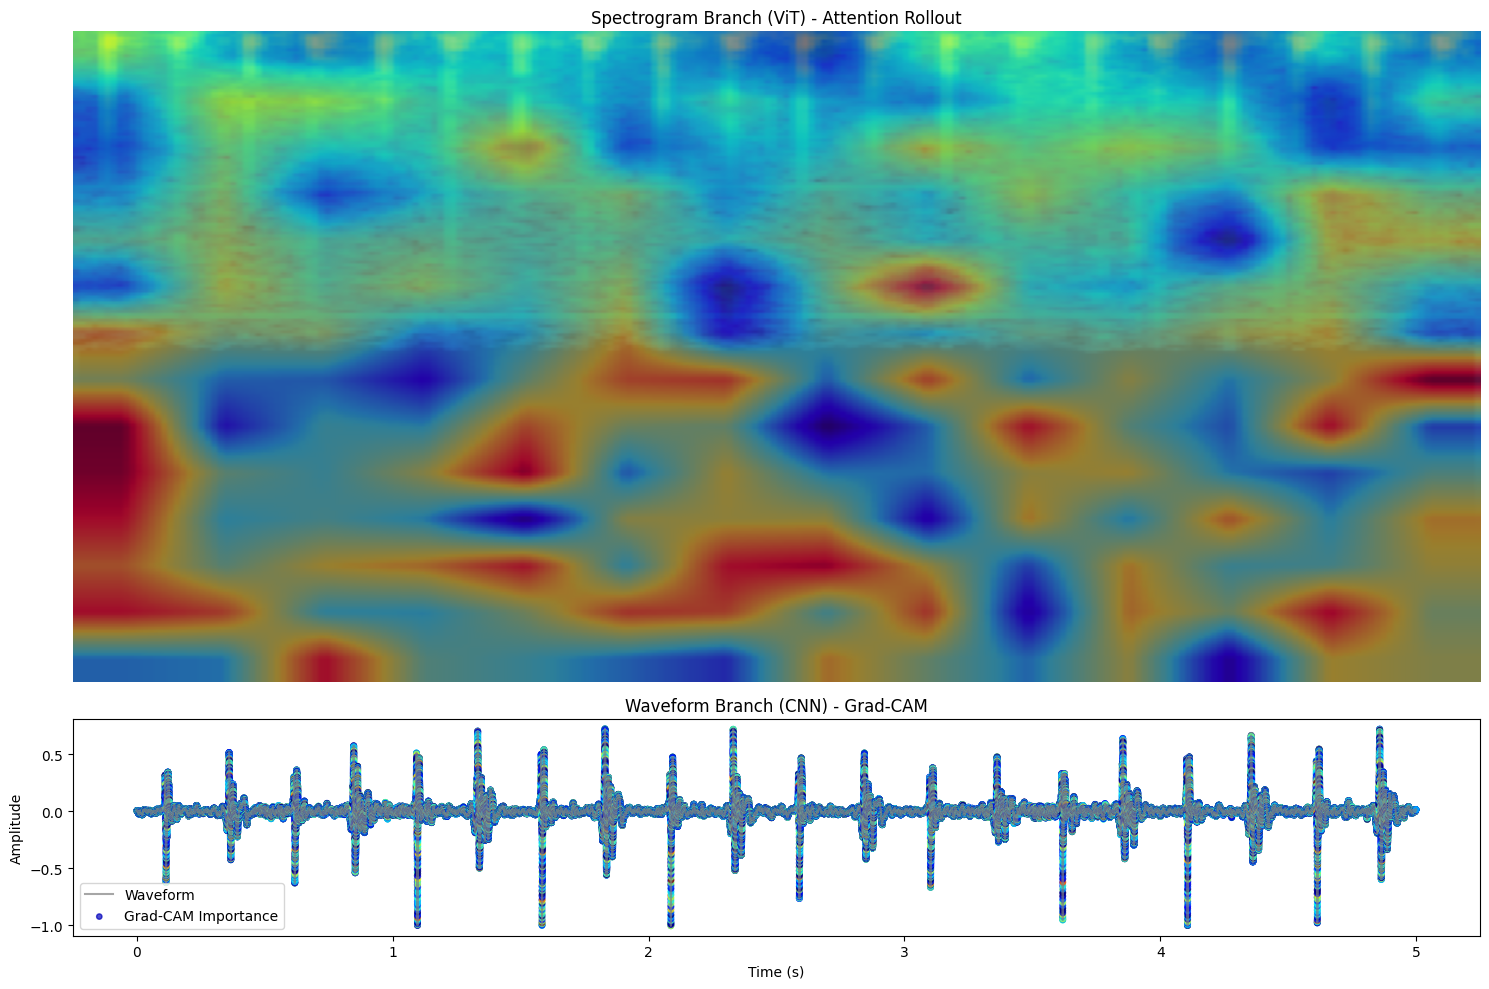

------------------------------------------------------------
Explaining Sample 2: True Label = 0, Predicted Label = 1


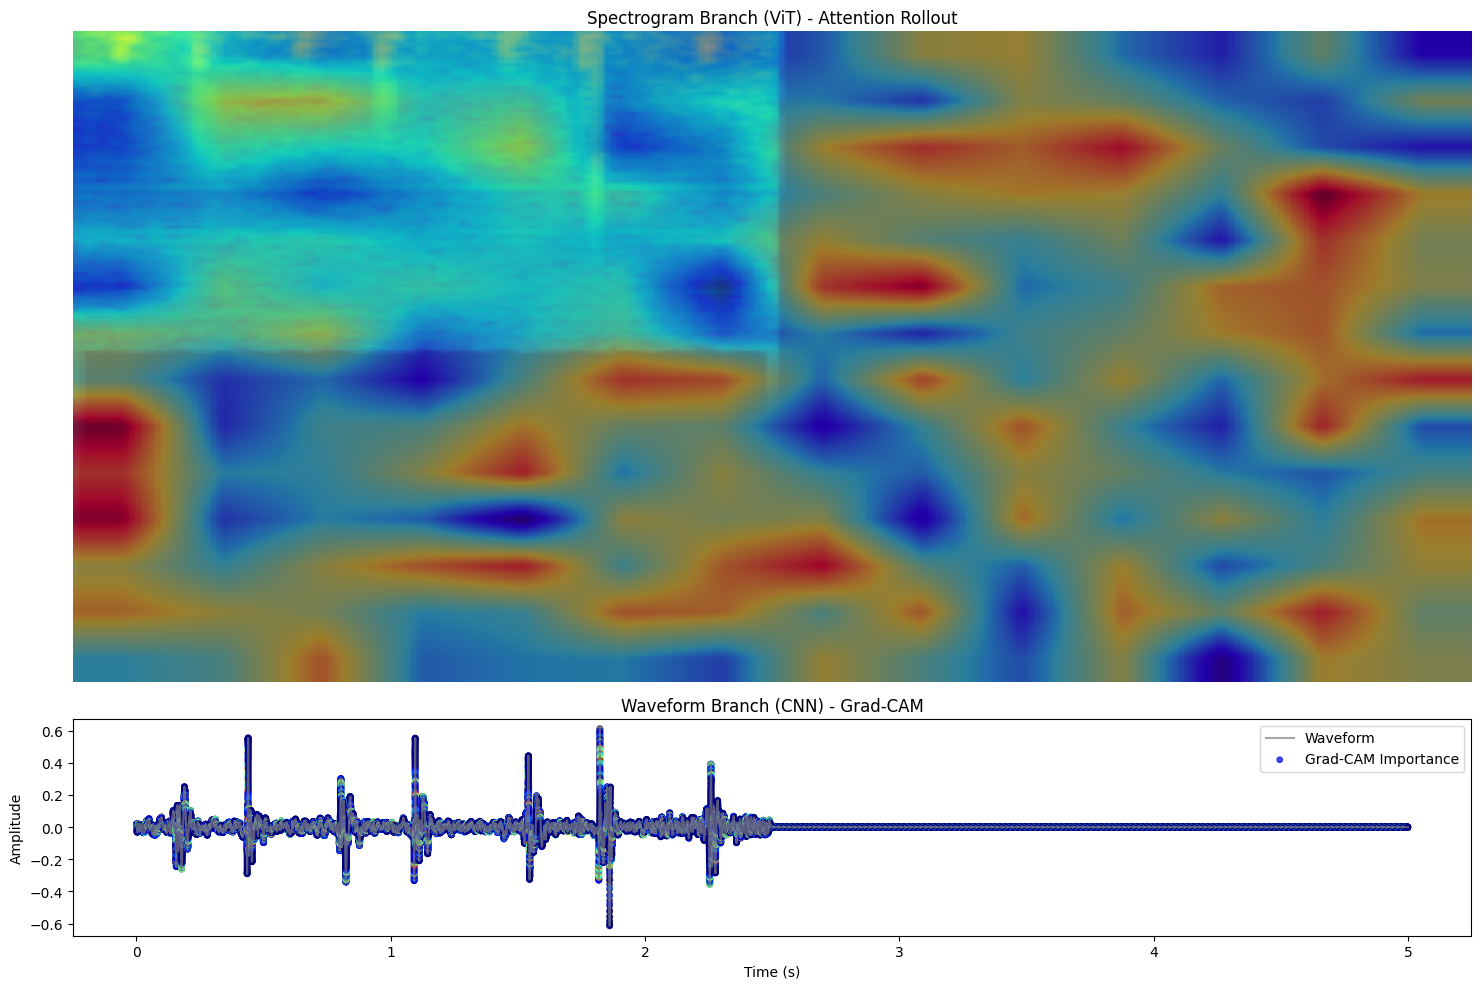

------------------------------------------------------------
Explaining Sample 3: True Label = 1, Predicted Label = 1


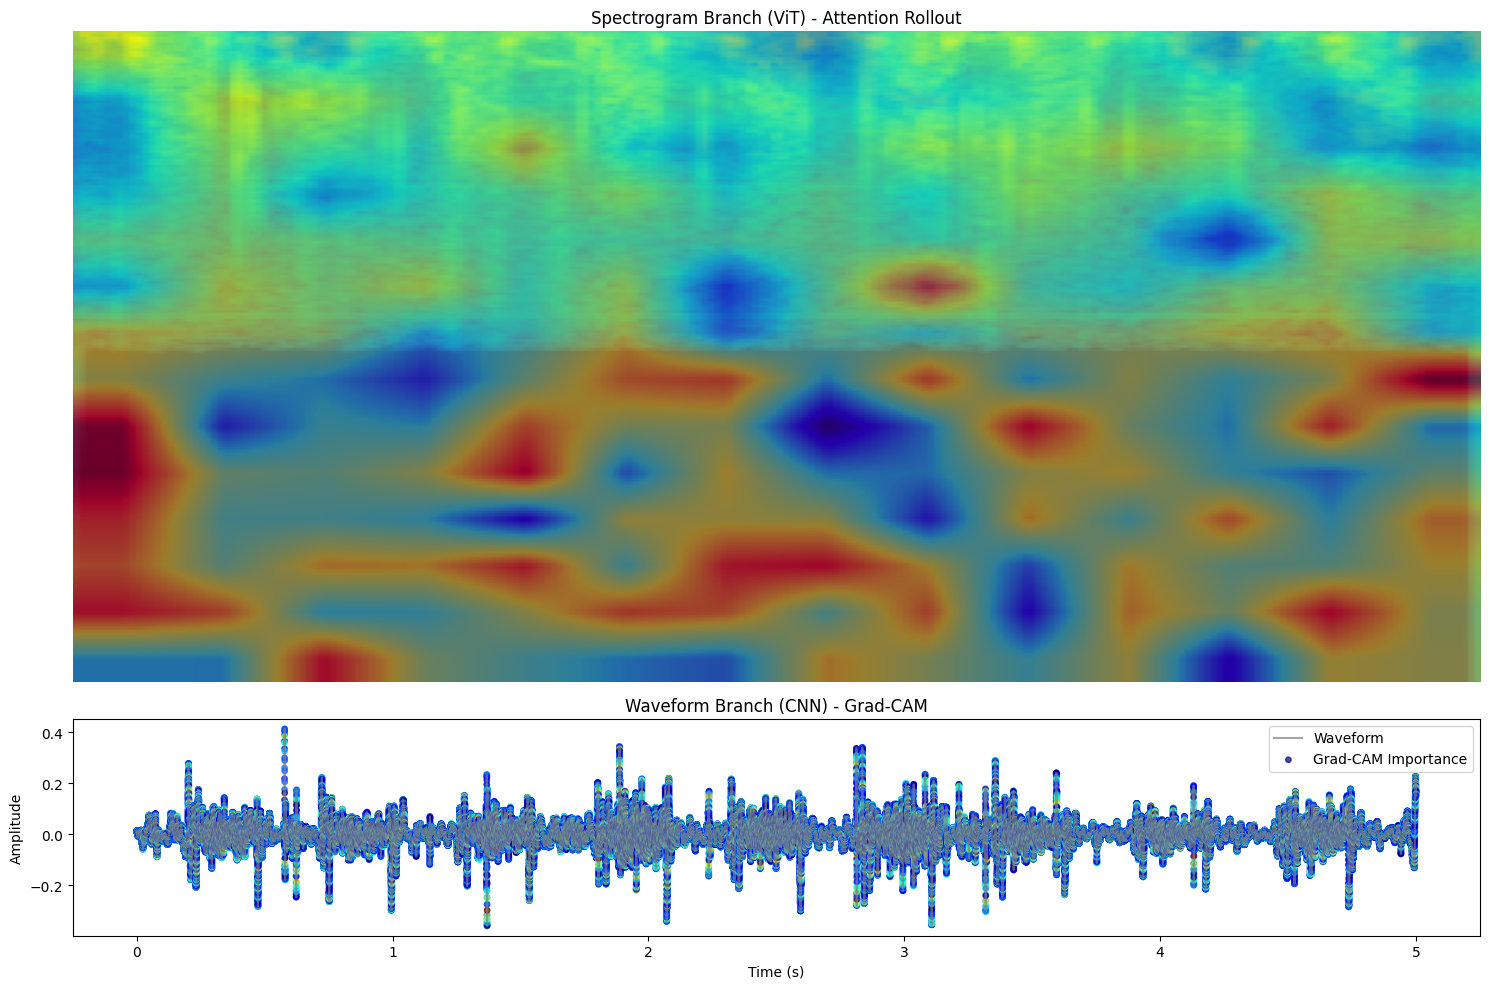


Analyzing Modality Contribution...


Analyzing Modalities:   0%|          | 0/88 [00:00<?, ?it/s]


Average Spectrogram Feature Norm: 10.1562
Average Waveform Feature Norm:  0.0274

The Spectrogram branch appears to be more influential by a factor of 370.25x.


In [ ]:
# ================================================================
# Block 8: Explainable AI for Hybrid Fusion Model
# ================================================================
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

print("Setting up Explainable AI components for the Hybrid Model...")

# --- Part 1: Loading the Best Trained Model (Our Source of Truth for Weights) ---
print(f"Loading best trained model from: {checkpoint_filepath}")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed}
)

# ================================================================
# Part 2: XAI for the Spectrogram ViT Branch (Attention Rollout)
# ================================================================

# --- Step 2A: Rebuilding the Model Architecture to get Attention Scores ---
def create_vit_explainer_model():
    """
    Rebuilds the ViT branch of our hybrid model, but configures the MHA layers
    to return their attention scores as an additional output.
    """
    spec_input = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spec_input")

    # Recreating the ViT branch exactly as before
    spec_patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM, name="spec_patch_embed")(spec_input)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    spec_pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM, name="spec_pos_embedding")
    positions = tf.range(start=0, limit=num_patches, delta=1)
    spec_encoded = spec_patch_embed + spec_pos_embedding(positions)

    attention_score_outputs = [] # List to hold the score tensors

    for i in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"spec_norm1_layer_{i}")(spec_encoded)

        # Creating a new MHA layer instance with the same parameters as the original
        attn_layer = layers.MultiHeadAttention(
            num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS,
            dropout=CONFIG.DROPOUT_RATE, name=f"spec_mha_layer_{i}"
        )

        # Calling it to get both outputs
        attention_output, attention_scores = attn_layer(x1, x1, return_attention_scores=True)
        attention_score_outputs.append(attention_scores)

        x2 = layers.Add(name=f"spec_add1_layer_{i}")([attention_output, spec_encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6, name=f"spec_norm2_layer_{i}")(x2)
        for j, units in enumerate(CONFIG.MLP_UNITS):
            x3 = layers.Dense(units, activation=tf.nn.gelu, name=f"spec_mlp_{i}_dense_{j}")(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE, name=f"spec_mlp_{i}_dropout_{j}")(x3)
        spec_encoded = layers.Add(name=f"spec_add2_layer_{i}")([x3, x2])

    # The explainer model only needs to output the attention scores
    explainer = keras.Model(inputs=spec_input, outputs=attention_score_outputs)
    return explainer

# --- Step 2B: Instantiating the Explainer and Manually Copying Weights ---
spec_explainer = create_vit_explainer_model()

print("Copying weights from trained model to ViT explainer model...")
# Iterating through layers and copying weights by name
for layer in best_model.layers:
    try:
        explainer_layer = spec_explainer.get_layer(name=layer.name)
        explainer_layer.set_weights(layer.get_weights())
    except ValueError:
        # This will happen for layers that are not in the explainer (e.g., waveform branch)
        pass
print("ViT explainer model is ready.")


# --- Step 2C: Attention Rollout Algorithm ---
def compute_attention_rollout(attention_scores_list):
    num_patches = attention_scores_list[0].shape[-1]
    rollout = np.eye(num_patches, num_patches)
    for attention_map_batch in attention_scores_list:
        attention_map = attention_map_batch[0]
        avg_head_map = np.mean(attention_map, axis=0)
        residual_map = avg_head_map + np.eye(avg_head_map.shape[0])
        residual_map = residual_map / residual_map.sum(axis=-1, keepdims=True)
        rollout = np.matmul(residual_map, rollout)
    return rollout

# ================================================================
# Part 3: XAI for the Waveform CNN Branch (Grad-CAM)
# ================================================================

# --- Step 3A: Grad-CAM Algorithm for 1D Signals ---
def make_gradcam_heatmap_1d(waveform_array, model, last_conv_layer_name, pred_index=None):
    # Creating a model that maps BOTH inputs to the last conv layer and the final prediction
    grad_model = keras.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Creating a dummy spectrogram input of the correct shape
    dummy_spec = tf.zeros((1, CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), dtype=tf.float16)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([dummy_spec, waveform_array])
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()

# Finding the name of the last Conv1D layer in our trained model
last_conv_layer_name_1d = [l.name for l in best_model.layers if isinstance(l, layers.Conv1D)][-1]
print(f"Waveform CNN explainer will use layer: {last_conv_layer_name_1d}")

# ================================================================
# Part 4: Combined Visualization and Analysis Loop
# ================================================================

# --- Creating a finite, non-repeating validation set for explanation ---
val_ds_eval = create_hybrid_dataset(val_df).batch(1).prefetch(tf.data.AUTOTUNE)

for i, (data, labels) in enumerate(val_ds_eval.take(3)):
    spec_sample = data['spec_input']
    wave_sample = data['wave_input']
    true_label = labels.numpy()[0]

    pred = best_model.predict_on_batch(data)
    pred_label = np.argmax(pred[0]) if NUM_CLASSES > 2 else (tf.nn.sigmoid(pred).numpy()[0,0] > 0.5).astype(int)

    print("-" * 60)
    print(f"Explaining Sample {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")

    # 1. Generating Spectrogram Attention
    attention_scores = spec_explainer.predict_on_batch(spec_sample)
    rollout_map = compute_attention_rollout(attention_scores)
    patch_importance = rollout_map.mean(axis=0)
    num_patches_side = int(np.sqrt(len(patch_importance)))
    heatmap_2d = patch_importance.reshape(num_patches_side, num_patches_side)
    heatmap_2d_resized = cv2.resize(heatmap_2d / heatmap_2d.max(), (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))

    # 2. Generating Waveform Grad-CAM
    heatmap_1d = make_gradcam_heatmap_1d(wave_sample, best_model, last_conv_layer_name_1d)

    # 3. Plotting Both Explanations
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(spec_sample[0], cmap='viridis', aspect='auto'); axs[0].imshow(heatmap_2d_resized, cmap='jet', alpha=0.5, aspect='auto')
    axs[0].set_title("Spectrogram Branch (ViT) - Attention Rollout"); axs[0].axis('off')

    waveform_to_plot = wave_sample[0].numpy()
    time_axis = np.arange(len(waveform_to_plot)) / 22050.0
    heatmap_1d_resized = np.resize(heatmap_1d, waveform_to_plot.shape)

    axs[1].plot(time_axis, waveform_to_plot, color='gray', alpha=0.7, label='Waveform')
    axs[1].scatter(time_axis, waveform_to_plot, c=heatmap_1d_resized, cmap='jet', s=15, alpha=0.7, label='Grad-CAM Importance')
    axs[1].set_title("Waveform Branch (CNN) - Grad-CAM"); axs[1].set_xlabel("Time (s)"); axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    plt.tight_layout(); plt.show()

# ================================================================
# Part 4: Analyzing Modality Contribution
# ================================================================
print("\n" + "=" * 50)
print("Analyzing Modality Contribution...")

spec_branch_output = best_model.get_layer("spec_gap").output
wave_branch_output = best_model.get_layer("waveform_funnel").output

modality_model = keras.Model(inputs=best_model.inputs, outputs=[spec_branch_output, wave_branch_output])
spec_norms, wave_norms = [], []

for data, labels in tqdm(val_ds_eval, desc="Analyzing Modalities"):
    spec_features, wave_features = modality_model.predict_on_batch(data)
    spec_norms.extend(np.linalg.norm(spec_features, axis=-1))
    wave_norms.extend(np.linalg.norm(wave_features, axis=-1))

avg_spec_norm = np.mean(spec_norms)
avg_wave_norm = np.mean(wave_norms)

print(f"\nAverage Spectrogram Feature Norm: {avg_spec_norm:.4f}")
print(f"Average Waveform Feature Norm:  {avg_wave_norm:.4f}")

if avg_spec_norm > avg_wave_norm:
    ratio = avg_spec_norm / avg_wave_norm
    print(f"\nThe Spectrogram branch appears to be more influential by a factor of {ratio:.2f}x.")
else:
    ratio = avg_wave_norm / avg_spec_norm
    print(f"\nThe Waveform branch appears to be more influential by a factor of {ratio:.2f}x.")

# **Spectrogram-Only Baseline**

# **Data Preparation**

In [ ]:
# ================================================================
# Block 4: Data Pipeline (Spectrogram-Only)
# ================================================================
from sklearn.utils import class_weight

def load_and_extract_spectrogram(npy_path, label):
    def _load_and_extract(path):
        full_image = np.load(path.numpy().decode('utf-8'))
        return full_image[:, :, 0:1] # Slice for spectrogram
    [image] = tf.py_function(_load_and_extract, [npy_path], [tf.float32])
    image.set_shape((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS))
    label.set_shape([])
    return image, label

def create_fast_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['npy_filepath'].values, df['label'].values))
    dataset = dataset.map(load_and_extract_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle: ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_fast_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_fast_dataset(val_df))
print("\nSpectrogram-Only Data pipeline ready.")

# --- Calculating Class Weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'].values)
class_weight_dict = dict(enumerate(class_weights))
print("\nCalculated Class Weights:", class_weight_dict)


Spectrogram-Only Data pipeline ready.

Calculated Class Weights: {0: np.float64(0.6985018726591761), 1: np.float64(1.759433962264151)}


## **Model Building**

In [ ]:
# Enabling mixed precision for speed boost
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision enabled: {mixed_precision.global_policy().name}")

@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    """Efficiently create and project patches using a Conv2D layer."""
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

# --- The Spectrogram-Only ViT Architecture ---
def create_spectrogram_vit(num_classes):
    # A single input for the spectrogram
    inputs = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spectrogram_input")

    # Creating and encoding patches
    patches = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM)(inputs)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    pos_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + pos_embedding_layer(positions)

    # Transformer Encoder blocks
    for _ in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)

        encoded_patches = layers.Add()([x3, x2])

    # Classifier Head
    representation = layers.LayerNormalization(epsilon=1e-6, name="ln_final")(encoded_patches)
    pooled_output = layers.GlobalAveragePooling1D()(representation)

    if num_classes == 2:
        output_activation, output_units = None, 1
    else:
        output_activation, output_units = "softmax", num_classes

    outputs = layers.Dense(output_units, activation=output_activation, dtype='float32', name='predictions')(pooled_output)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiating the new, simpler model
NUM_CLASSES = train_df['label'].nunique()
model = create_spectrogram_vit(num_classes=NUM_CLASSES)
model.summary()

Mixed precision enabled: mixed_float16


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed_2       │ (None, 196, 192)  │     49,344 │ spectrogram_inpu… │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 196, 192)  │          0 │ patch_embed_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_116         │ (None, 196, 384)  │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 196, 192)  │     73,920 │ dropout_116[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_117         │ (None, 196, 192)  │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 196, 192)  │          0 │ dropout_117[0][0… │
│                     │                   │            │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_29[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_119         │ (None, 196, 384)  │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 1,832,065 (6.99 MB)

 Trainable params: 1,832,065 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [ ]:
# ================================================================
# Block 5: Model Loading, Freezing, and Fine-Tuning
# ================================================================
import math

# --- Step 1: Defining the Model Architecture (IDENTICAL to the saved model) ---
@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

def create_spectrogram_vit(num_classes):
    # The from-scratch ViT architecture we used for the baseline
    inputs = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS))
    patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM)(inputs)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    pos_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patch_embed + pos_embedding_layer(positions)
    for _ in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attn = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)(x1, x1)
        x2 = layers.Add()([attn, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6, name="ln_final")(encoded_patches)
    pooled_output = layers.GlobalAveragePooling1D()(representation)
    outputs = layers.Dense(1, activation=None, dtype='float32', name='predictions')(pooled_output)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Step 2: Loading the Pre-trained PhysioNet Model ---
PHYSIO_MODEL_PATH = "/content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_spectrogram_physionet.keras"
print(f"Loading pre-trained spectrogram model from: {PHYSIO_MODEL_PATH}")
model = keras.models.load_model(PHYSIO_MODEL_PATH, custom_objects={'PatchEmbed': PatchEmbed})

# --- Step 3: Freezing the Backbone ---
print("\nFreezing backbone layers...")

for layer in model.layers:
    if 'pool' in layer.name or 'predictions' in layer.name or 'dropout' in layer.name or 'dense_11' in layer.name:
         pass
    else:
        layer.trainable = False

# Specifically, we only want to train the final Dense layer.
model.get_layer('global_average_pooling1d').trainable = False # GAP has no weights, but good practice
# Ensuring dropout before the last layer is not trainable
if 'dropout' in model.layers[-2].name:
    model.layers[-2].trainable = False
model.get_layer('dense_12').trainable = True

# --- Step 4: Compiling the Model for Fine-Tuning ---
optimizer = tf.keras.optimizers.AdamW(learning_rate=CONFIG.LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
)
print("\nModel compiled for fine-tuning the head:")
model.summary()

# --- Step 5: Defining Callbacks ---
checkpoint_filepath = "best_model_spectrogram_PASCAL_finetuned.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_auc', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_auc', patience=40, restore_best_weights=True)
]

# --- Step 6: Training the Model ---
steps_per_epoch = math.ceil(len(train_df) / CONFIG.BATCH_SIZE)
validation_steps = math.ceil(len(val_df) / CONFIG.BATCH_SIZE)

print(f"\nStarting fine-tuning with {steps_per_epoch} steps per epoch...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS + 100,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict
)
print("Fine-tuning complete.")

Loading pre-trained spectrogram model from: /content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_spectrogram_physionet.keras

Freezing backbone layers...

Model compiled for fine-tuning the head:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed         │ (None, 196, 192)  │     49,344 │ spectrogram_inpu… │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 192)  │          0 │ patch_embed[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 192)  │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 384)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 192)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 192)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 384)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,832,065 (6.99 MB)

 Trainable params: 74,113 (289.50 KB)

 Non-trainable params: 1,757,952 (6.71 MB)


Starting fine-tuning with 3 steps per epoch...
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7207 - auc: 0.4670 - loss: 0.7595 - val_accuracy: 0.6016 - val_auc: 0.3723 - val_loss: 0.7811
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.7018 - auc: 0.3970 - loss: 0.7592 - val_accuracy: 0.5859 - val_auc: 0.2716 - val_loss: 0.7867
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.6914 - auc: 0.3993 - loss: 0.7364 - val_accuracy: 0.5547 - val_auc: 0.2448 - val_loss: 0.7965
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.6585 - auc: 0.3835 - loss: 0.7114 - val_accuracy: 0.5547 - val_auc: 0.2120 - val_loss: 0.7991
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.6071 - auc: 0.4346 - loss: 0.7150 - val_accuracy: 0.4922 - val_auc: 0.2185 - val_loss: 0.7983
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.6488 - auc: 0.4164 - loss: 0.7197 - val_accuracy: 0.6016 - val_auc: 0.2056 - val_loss: 0.7897


## **Evaluation**


Loading best model for final evaluation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 114 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 110 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Extracting true labels...

Plotting training and validation history...


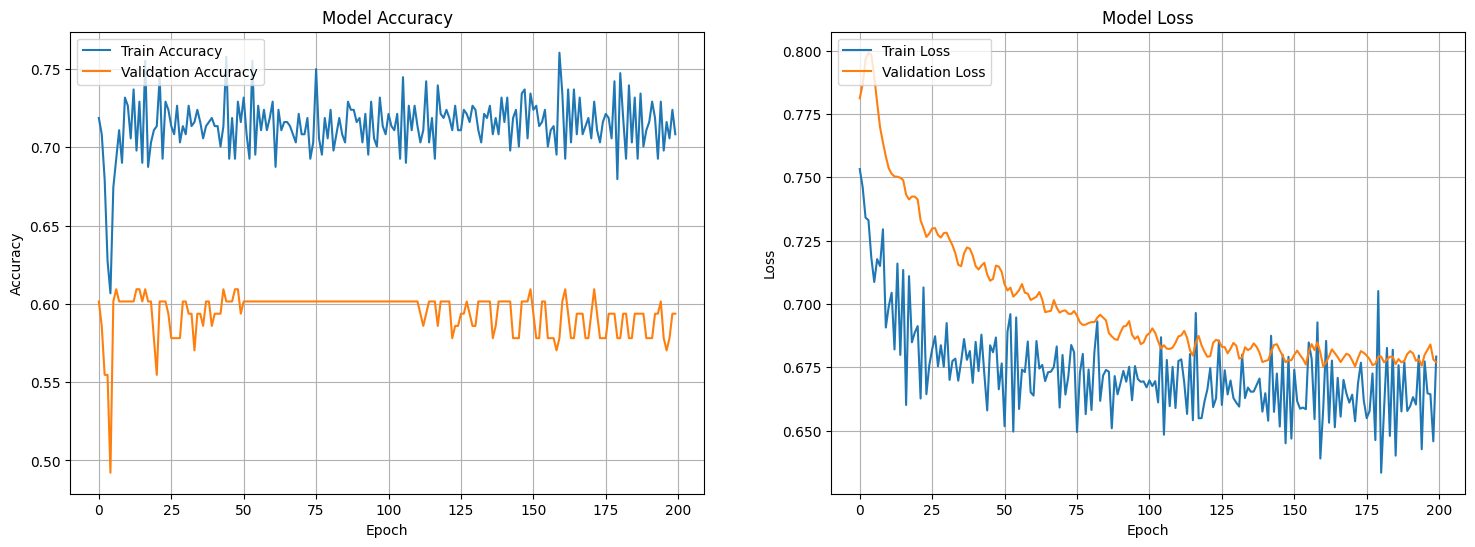


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.0579
Cohen's Kappa Score: 0.0535
AUC-ROC Score: 0.4873

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6176    0.7925    0.6942        53
    Abnormal     0.4500    0.2571    0.3273        35

    accuracy                         0.5795        88
   macro avg     0.5338    0.5248    0.5107        88
weighted avg     0.5510    0.5795    0.5483        88


Plotting Confusion Matrix...


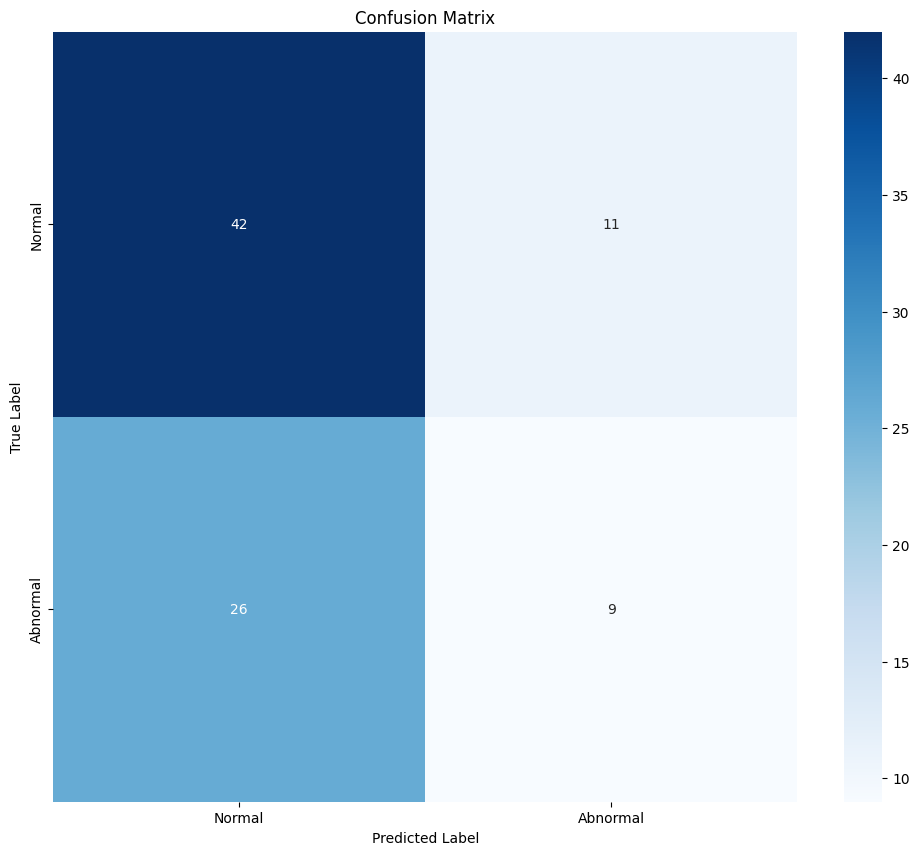


Plotting ROC Curves...


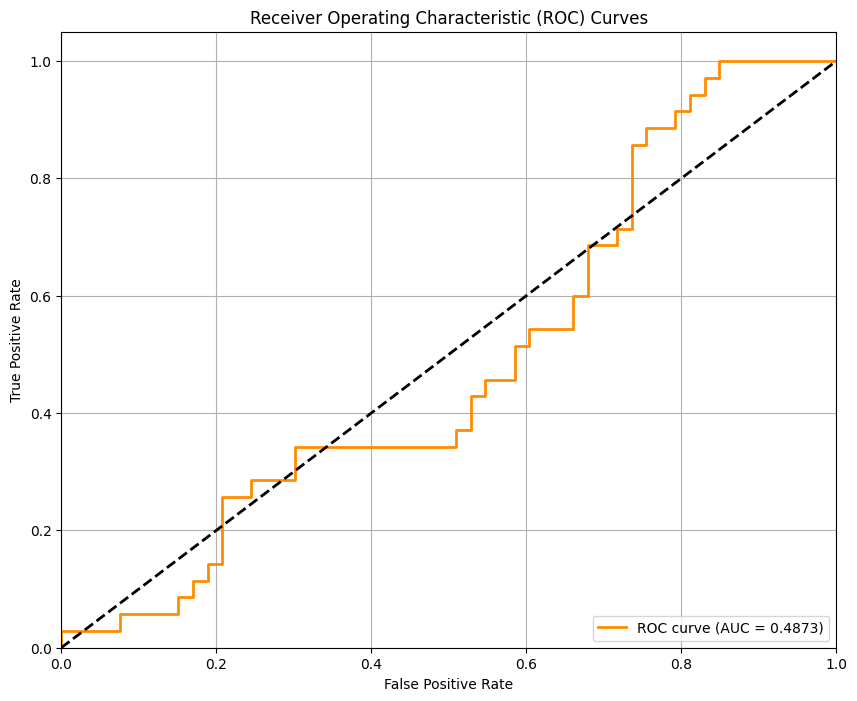

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation (Corrected)
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed}
)

print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_fast_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# -----------------------------------------------------------------

# --- Getting predictions on the validation set ---
print("Generating predictions on the validation set...")
predictions = best_model.predict(val_ds_eval)

# --- Getting true labels from the validation set ---
print("Extracting true labels...")
y_true = np.concatenate([y for x, y in val_ds_eval], axis=0).astype(int)

num_samples = len(val_df)
y_true = y_true[:num_samples]
predictions = predictions[:num_samples]


# --- Processing predictions based on the task ---
if NUM_CLASSES == 2:
    y_prob = tf.nn.sigmoid(predictions).numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)
else:
    y_prob = predictions
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy'); ax1.set_ylabel('Accuracy'); ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left'); ax1.grid(True)
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss'); ax2.set_ylabel('Loss'); ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left'); ax2.grid(True)
plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
try:
    class_names = [name for name, index in sorted(class_to_id.items(), key=lambda item: item[1])]
except NameError:
    class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))
if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc_i = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc_i:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right"); plt.grid(True)
plt.show()

## **XAI & Attention Rollout**

Setting up Explainable AI components for the Spectrogram-Only model...
Created explainer model with 6 attention outputs.
--------------------------------------------------
Explaining Sample 1: True Label = 0, Predicted Label = 0


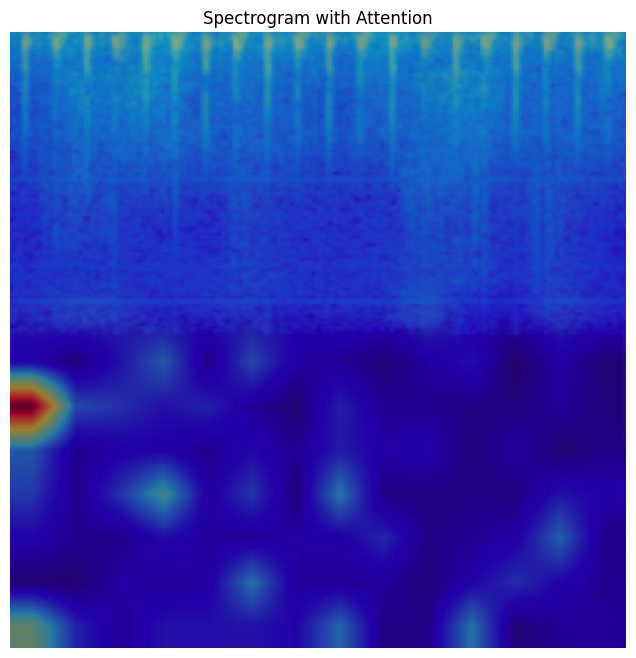

--------------------------------------------------
Explaining Sample 2: True Label = 0, Predicted Label = 0


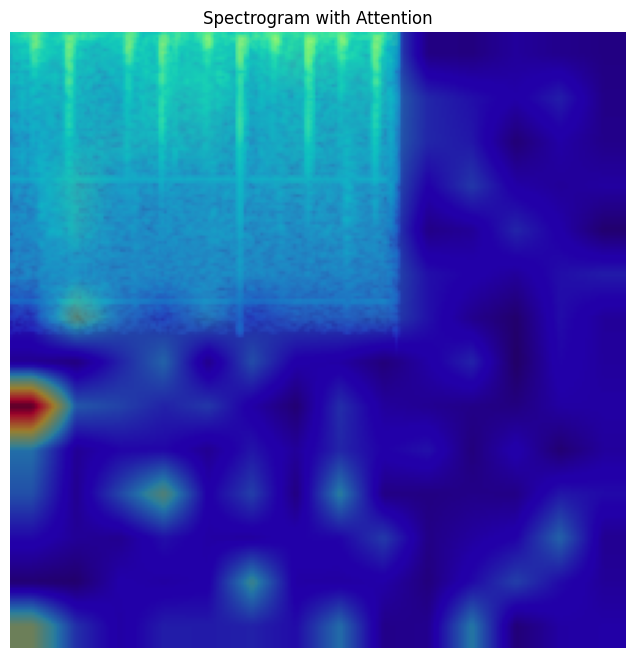

--------------------------------------------------
Explaining Sample 3: True Label = 0, Predicted Label = 1


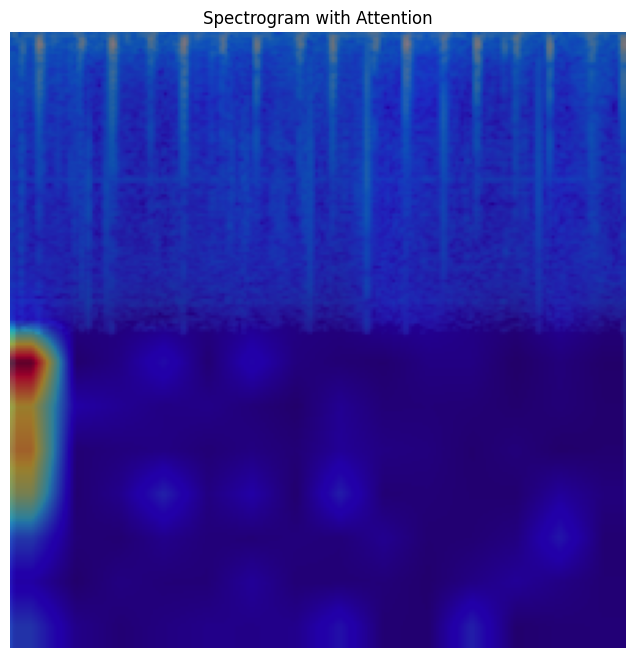

In [ ]:
# ===================================================================
# Block 8: Explainable AI (XAI) for Spectrogram-Only Model
# ===================================================================
import cv2
from tqdm.notebook import tqdm

print("Setting up Explainable AI components for the Spectrogram-Only model...")

# --- Part 1: Rebuilding the Model to Output Attention Scores ---
# This function is now simplified for a single input stream.
def create_explainer_model(num_classes):
    inputs = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spectrogram_input")
    patches = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM)(inputs)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    pos_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + pos_embedding_layer(positions)
    encoded_patches = layers.Dropout(CONFIG.DROPOUT_RATE)(encoded_patches)

    attention_outputs = []
    for _ in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attn_layer = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)
        attention_output, attention_scores = attn_layer(x1, x1, return_attention_scores=True)
        attention_outputs.append(attention_scores) # Save the scores
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)
        x4 = layers.Add()([x3, x2])
        encoded_patches = layers.Dropout(CONFIG.DROPOUT_RATE)(x4)

    return keras.Model(inputs=inputs, outputs=attention_outputs)

explainer_model = create_explainer_model(num_classes=NUM_CLASSES)
explainer_model.load_weights(checkpoint_filepath)
print(f"Created explainer model with {len(explainer_model.outputs)} attention outputs.")


# --- Part 2: Attention Rollout Algorithm ---
def compute_attention_rollout(attention_scores_list):
    num_patches = attention_scores_list[0].shape[-1]
    rollout = np.eye(num_patches, num_patches)
    for attention_map_batch in attention_scores_list:
        attention_map = attention_map_batch[0]
        avg_head_map = np.mean(attention_map, axis=0)
        residual_map = avg_head_map + np.eye(avg_head_map.shape[0])
        residual_map = residual_map / residual_map.sum(axis=-1, keepdims=True)
        rollout = np.matmul(residual_map, rollout)
    return rollout

# --- Part 3: Visualization Function ---
def plot_explanation(sample_image, attention_rollout_map):
    spec_img = sample_image[0].numpy()
    patch_importance = attention_rollout_map.mean(axis=0)
    num_patches_side = int(np.sqrt(len(patch_importance)))
    heatmap = patch_importance.reshape(num_patches_side, num_patches_side)
    heatmap_resized = cv2.resize(heatmap / heatmap.max(), (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))

    plt.figure(figsize=(8, 8))
    plt.imshow(spec_img, cmap='viridis')
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Spectrogram with Attention")
    plt.axis('off')
    plt.show()

# --- Part 4: Generating Explanations ---
for i, (image, label) in enumerate(val_ds.take(3)):
    pred = best_model.predict_on_batch(image)

    if NUM_CLASSES == 2:
        pred_label = 1 if tf.nn.sigmoid(pred).numpy().flatten()[0] > 0.5 else 0
    else:
        pred_label = np.argmax(pred[0])

    true_label = int(label[0].numpy())

    print("-" * 50)
    print(f"Explaining Sample {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")

    # Passing the 'image' tensor directly to the explainer.
    attention_scores = explainer_model.predict_on_batch(image)
    rollout_map = compute_attention_rollout(attention_scores)

    # Passing the 'image' tensor directly to the plotting function.
    plot_explanation(image, rollout_map)

# **Waveform-Only Baseline**

## **Data Pipeline**

In [ ]:
# ================================================================
# Block 4: Data Pipeline (Waveform-Only)
# ================================================================
from sklearn.utils import class_weight
import librosa

WAVEFORM_MAX_LEN = int(CONFIG.WAVEFORM_LENGTH_SECONDS * 22050)

def load_wav_only(wav_path, label):
    def _py_load_wav(path):
        import numpy as np
        path_str = path.numpy().decode('utf-8')
        wav, _ = librosa.load(path_str, sr=22050, mono=True)
        if len(wav) > WAVEFORM_MAX_LEN: wav = wav[:WAVEFORM_MAX_LEN]
        else: wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')
        return wav.astype(np.float32)
    [waveform] = tf.py_function(_py_load_wav, [wav_path], [tf.float32])
    waveform.set_shape([WAVEFORM_MAX_LEN])
    label.set_shape([])
    return waveform, label

def create_wav_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    dataset = dataset.map(load_wav_only, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle: ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_wav_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_wav_dataset(val_df))
print("\nWaveform-Only Data pipeline ready.")

# --- Calculating Class Weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'].values)
class_weight_dict = dict(enumerate(class_weights))
print("\nCalculated Class Weights:", class_weight_dict)


Waveform-Only Data pipeline ready.

Calculated Class Weights: {0: np.float64(0.6985018726591761), 1: np.float64(1.759433962264151)}


In [ ]:
# ================================================================
# Block 4: Fast Data Pipeline (Waveform-Only)
# ================================================================

# --- Ensuring WAV file paths are present and correct ---
assert 'filepath' in train_df.columns, "The 'filepath' column (for .wav files) is missing from the training metadata."
assert os.path.exists(train_df.iloc[0]['filepath']), f"Could not find WAV file at {train_df.iloc[0]['filepath']}. Did you unzip the original dataset?"

WAVEFORM_MAX_LEN = int(CONFIG.WAVEFORM_LENGTH_SECONDS * 22050)

# --- This function now only loads the waveform ---
def load_wav_only(wav_path, label):
    def _load_wav(path):
        # Importing necessary libraries INSIDE the function for parallel execution
        import librosa
        import numpy as np

        path_str = path.numpy().decode('utf-8')
        wav, _ = librosa.load(path_str, sr=22050, mono=True)

        # Padding or truncating to a fixed length
        if len(wav) > WAVEFORM_MAX_LEN:
            wav = wav[:WAVEFORM_MAX_LEN]
        else:
            wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')
        return wav

    [waveform] = tf.py_function(_load_wav, [wav_path], [tf.float32])
    waveform.set_shape([WAVEFORM_MAX_LEN])
    label.set_shape([])

    # Returning a simple (waveform, label) tuple
    return waveform, label

# --- Creating the tf.data.Dataset objects using the new function ---
def create_wav_dataset(df):
    # We now only need the original 'filepath' and 'label' columns
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    dataset = dataset.map(load_wav_only, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_wav_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_wav_dataset(val_df))

print("\nWaveform-Only Data pipeline ready.")

# Verifying the output shape of a batch
for waveform, labels in train_ds.take(1):
    print(f"Waveform batch shape: {waveform.shape}")
    print(f"Labels batch shape: {labels.shape}")


Waveform-Only Data pipeline ready.
Waveform batch shape: (256, 110250)
Labels batch shape: (256,)


## **Model Building**

## **Training**

In [ ]:
# ================================================================
# Block 5: Model Loading, Freezing, and Fine-Tuning
# ================================================================
import math

# --- Step 1: Defining the Model Architecture (IDENTICAL to the saved model) ---
def create_waveform_cnn(num_classes):
    wave_input = layers.Input(shape=(WAVEFORM_MAX_LEN,), name="wave_input")
    wave_reshaped = layers.Reshape((-1, 1))(wave_input)
    x_1d = layers.Conv1D(64, kernel_size=16, strides=4, activation='relu', padding='same')(wave_reshaped)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)
    x_1d = layers.Conv1D(128, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)
    x_1d = layers.Conv1D(256, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    wave_pooled = layers.GlobalAveragePooling1D()(x_1d)
    wave_features = layers.Dense(64, activation='relu', name="waveform_funnel")(wave_pooled)
    x = layers.Dropout(0.5)(wave_features)
    outputs = layers.Dense(1, activation=None, dtype='float32', name="predictions")(x)
    model = keras.Model(inputs=wave_input, outputs=outputs)
    return model

# --- Step 2: Loading the Pre-trained PhysioNet Model ---
PHYSIO_MODEL_PATH = "/content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_waveform_baseline.keras"
print(f"Loading pre-trained waveform model from: {PHYSIO_MODEL_PATH}")
model = keras.models.load_model(PHYSIO_MODEL_PATH)

# --- Step 3: Freezing the Backbone ---
print("\nFreezing backbone layers...")
# And unfreezing the 'waveform_funnel' Dense layer, the Dropout, and the final 'predictions' Dense layer.
for layer in model.layers:
    if layer.name.startswith('conv1d') or layer.name.startswith('batch_normalization'):
        layer.trainable = False
    else:
        layer.trainable = True

# --- Step 4: Compiling the Model for Fine-Tuning ---
optimizer = tf.keras.optimizers.AdamW(learning_rate=CONFIG.LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
)
print("\nModel compiled for fine-tuning the head:")
model.summary()

# --- Step 5: Defining Callbacks ---
checkpoint_filepath = "best_model_waveform_PASCAL_finetuned.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

# --- Step 6: Training the Model ---
steps_per_epoch = math.ceil(len(train_df) / CONFIG.BATCH_SIZE)
validation_steps = math.ceil(len(val_df) / CONFIG.BATCH_SIZE)

print(f"\nStarting fine-tuning with {steps_per_epoch} steps per epoch...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict
)
print("Fine-tuning complete.")

Loading pre-trained waveform model from: /content/drive/MyDrive/Multimodal Audio Fusion/Experiments/PhysioNet Heart Sound/best_model_waveform_baseline.keras

Freezing backbone layers...

Model compiled for fine-tuning the head:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ wave_input (InputLayer)         │ (None, 110250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 110250, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 27563, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27563, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6890, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1723, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1723, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 430, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 108, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ waveform_funnel (Dense)         │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 658,624 (2.51 MB)


Starting fine-tuning with 3 steps per epoch...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5758 - auc: 0.4502 - loss: 1.4795 - val_accuracy: 0.5703 - val_auc: 0.5516 - val_loss: 0.9919
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 0.5869 - auc: 0.4704 - loss: 1.4143 - val_accuracy: 0.5859 - val_auc: 0.5797 - val_loss: 0.9232
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - accuracy: 0.6331 - auc: 0.5040 - loss: 1.3058 - val_accuracy: 0.5859 - val_auc: 0.5973 - val_loss: 0.8680
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - accuracy: 0.6237 - auc: 0.5105 - loss: 1.2546 - val_accuracy: 0.6172 - val_auc: 0.6090 - val_loss: 0.8199
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - accuracy: 0.6712 - auc: 0.5609 - loss: 1.1361 - val_accuracy: 0.6484 - val_auc: 0.6287 - val_loss: 0.7782
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 887ms/step - accuracy: 0.6846 - auc: 0.5307 - loss: 1.0208 - val_accuracy: 0.6875 - val_auc: 0.6341 - val_loss: 0.7426


## **Evaluation**


Loading best model for final evaluation...
Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Plotting training and validation history...


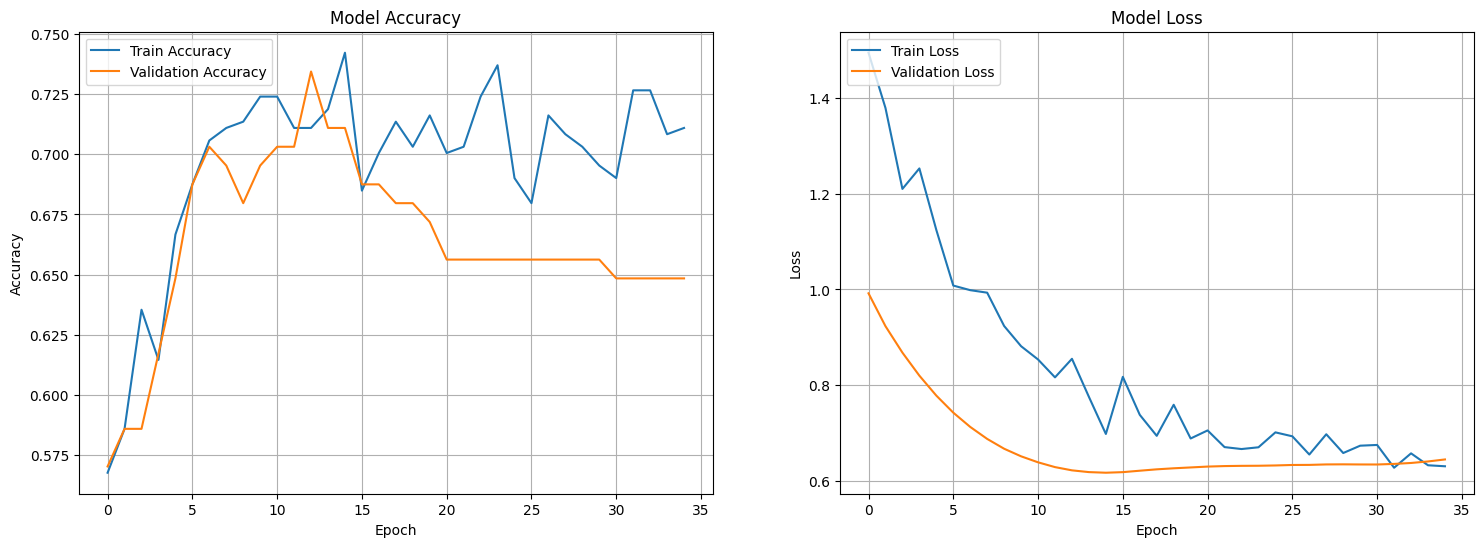


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.3152
Cohen's Kappa Score: 0.3090
AUC-ROC Score: 0.6782

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7049    0.8113    0.7544        53
    Abnormal     0.6296    0.4857    0.5484        35

    accuracy                         0.6818        88
   macro avg     0.6673    0.6485    0.6514        88
weighted avg     0.6750    0.6818    0.6725        88


Plotting Confusion Matrix...


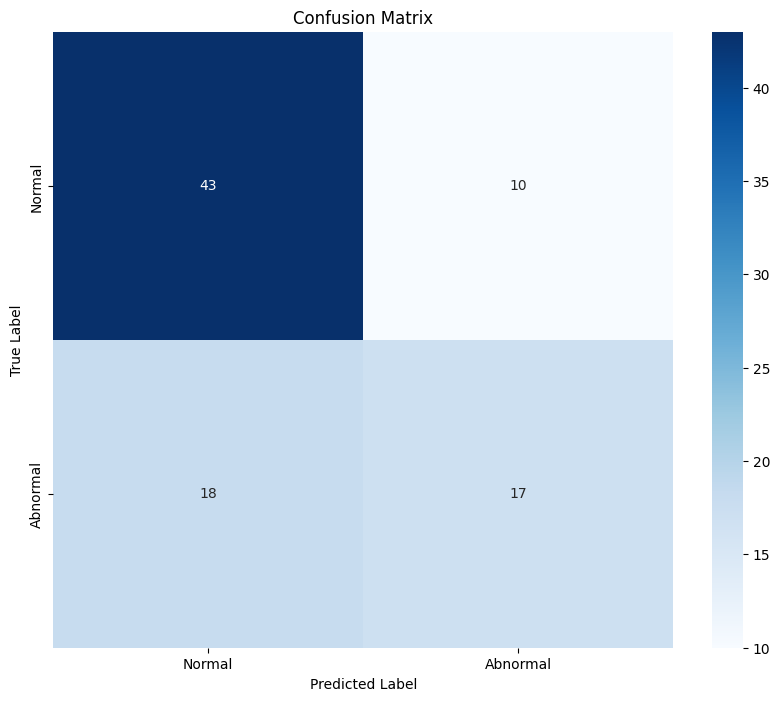


Plotting ROC Curves...


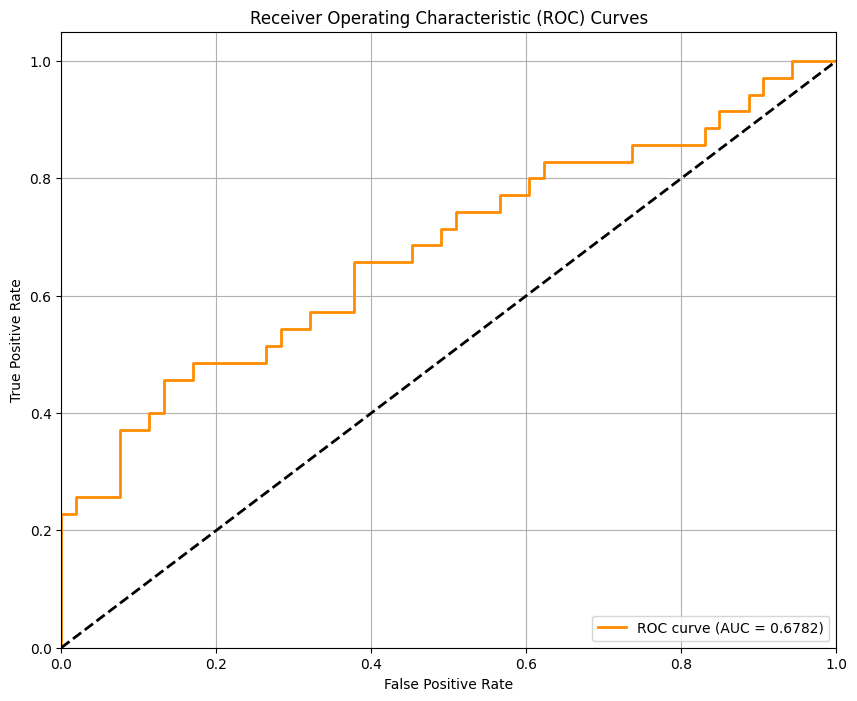

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation (Waveform-Only)
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(checkpoint_filepath)

# --- Creating a finite, non-repeating validation set for evaluation ---
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_wav_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions and true labels ---
print("Generating predictions on the validation set...")
y_prob = best_model.predict(val_ds_eval)
y_true = val_df['label'].values
if NUM_CLASSES == 2:
    y_pred = (tf.nn.sigmoid(y_prob).numpy().flatten() > 0.5).astype(int)
else:
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XAI**

Waveform CNN explainer will use layer: conv1d_2

--- Explaining 3 Random Samples ---


--------------------------------------------------
Explaining Sample 1 (File: normal_noisynormal_158_1306947254705_D.wav)
True Label: 0, Predicted Label: 1


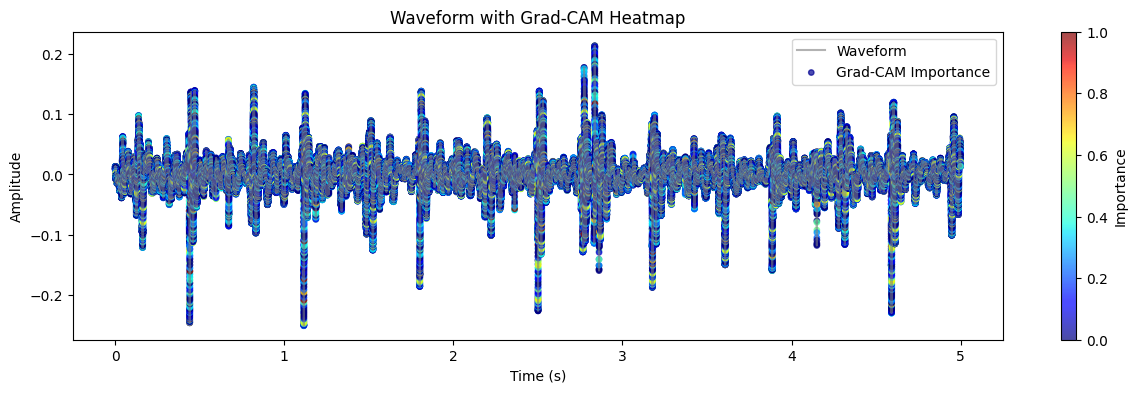

--------------------------------------------------
Explaining Sample 2 (File: normal__103_1305031931979_D2.wav)
True Label: 0, Predicted Label: 0


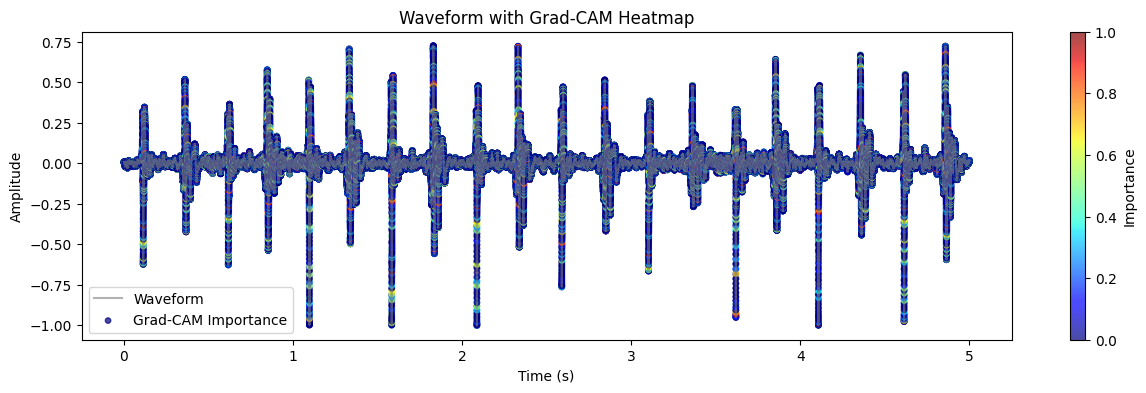

--------------------------------------------------
Explaining Sample 3 (File: murmur__254_1309350589009_C.wav)
True Label: 1, Predicted Label: 1


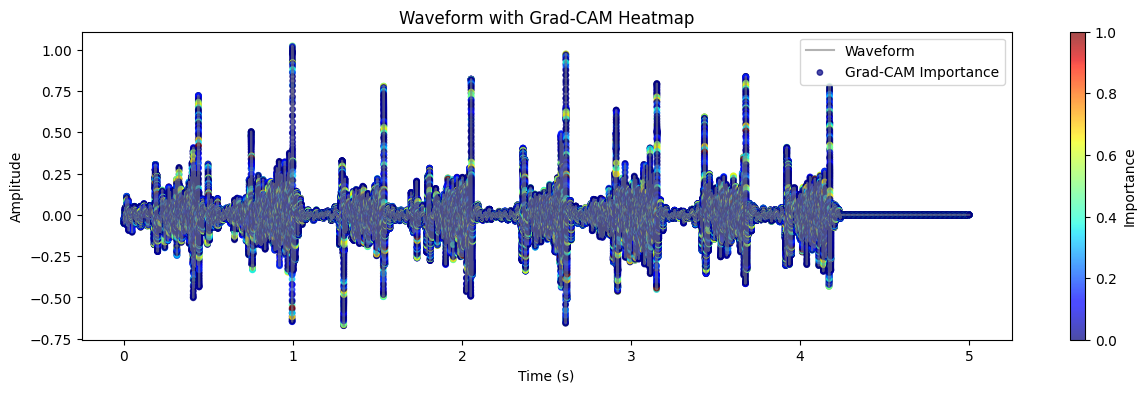

In [ ]:
# ================================================================
# Block 8: Explainable AI with Waveform CNN
# ================================================================
import cv2
import librosa

# --- Grad-CAM and plotting functions ---
def make_gradcam_heatmap_1d_standalone(waveform_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(waveform_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()

def plot_waveform_gradcam(waveform_sample, heatmap):
    fig, ax = plt.subplots(figsize=(15, 4))
    waveform_to_plot = waveform_sample[0].numpy()
    time_axis = np.arange(len(waveform_to_plot)) / 22050.0
    heatmap_resized = np.resize(heatmap, waveform_to_plot.shape)
    ax.plot(time_axis, waveform_to_plot, color='gray', alpha=0.6, label='Waveform')
    scatter = ax.scatter(time_axis, waveform_to_plot, c=heatmap_resized, cmap='jet', s=15, alpha=0.7, label='Grad-CAM Importance')
    ax.set_title("Waveform with Grad-CAM Heatmap")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    fig.colorbar(scatter, ax=ax, label='Importance')
    ax.legend()
    plt.show()

# --- Finding the last convolutional layer in our model ---
last_conv_layer_name_1d = [l.name for l in best_model.layers if isinstance(l, layers.Conv1D)][-1]
print(f"Waveform CNN explainer will use layer: {last_conv_layer_name_1d}")

# --- Generating explanations for a few RANDOM samples ---
# We are randomly sampling 3 rows from our validation DataFrame
num_samples_to_explain = 3
random_samples_df = val_df.sample(n=num_samples_to_explain, random_state=CONFIG.RANDOM_STATE)

print(f"\n--- Explaining {num_samples_to_explain} Random Samples ---")

for i, row in enumerate(random_samples_df.itertuples()):
    wav_path = row.filepath
    true_label = row.label

    # --- Manually loading and processing the single waveform ---
    wav, _ = librosa.load(wav_path, sr=22050, mono=True)
    if len(wav) > WAVEFORM_MAX_LEN:
        wav = wav[:WAVEFORM_MAX_LEN]
    else:
        wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')

    # Converting to a tensor and adding a batch dimension of 1
    waveform_tensor = tf.convert_to_tensor(wav, dtype=tf.float32)[tf.newaxis, :]

    # --- Getting model prediction for this single sample ---
    pred = best_model.predict(waveform_tensor, verbose=0)
    if NUM_CLASSES == 2:
        pred_label = (tf.nn.sigmoid(pred).numpy().flatten()[0] > 0.5).astype(int)
    else:
        pred_label = np.argmax(pred[0])

    print("-" * 50)
    print(f"Explaining Sample {i+1} (File: {os.path.basename(wav_path)})")
    print(f"True Label: {true_label}, Predicted Label: {pred_label}")

    # Generating the heatmap
    heatmap = make_gradcam_heatmap_1d_standalone(waveform_tensor, best_model, last_conv_layer_name_1d)

    # Displaying the superimposed image
    plot_waveform_gradcam(waveform_tensor, heatmap)

# **Model Training From Scratch**

Due to the very small size of the dataset, the from scratch implementation is unlikely to produce good results.

In [ ]:
# ================================================================
# Block 6: Model Training
# ================================================================

import math

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Re-creating the datasets with the corrected function
train_ds = configure_for_performance(create_hybrid_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_hybrid_dataset(val_df))
print("Data pipelines re-configured with .repeat() for multi-epoch training.")

# --- Selecting Loss and Metrics ---
if NUM_CLASSES == 2:
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
else:
    loss = keras.losses.SparseCategoricalCrossentropy()
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

# --- Compiling the model ---
optimizer = tf.keras.optimizers.AdamW(learning_rate=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- Defining Callbacks ---
checkpoint_filepath = "best_model_spec_wave_fusion_pascal.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# --- Adding steps_per_epoch and validation_steps to model.fit ---
steps_per_epoch = math.ceil(len(train_df) / CONFIG.BATCH_SIZE)
validation_steps = math.ceil(len(val_df) / CONFIG.BATCH_SIZE)
print(f"\nTraining with {steps_per_epoch} steps per epoch and {validation_steps} validation steps.")

# --- Training the model ---
print("\nStarting model training...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight_dict
)
print("Training complete.")

Data pipelines re-configured with .repeat() for multi-epoch training.

Training with 3 steps per epoch and 1 validation steps.

Starting model training...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 13s/step - accuracy: 0.6452 - auc: 0.5894 - loss: 0.7225 - val_accuracy: 0.6016 - val_auc: 0.5000 - val_loss: 0.7332
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6725 - auc: 0.5865 - loss: 0.7466 - val_accuracy: 0.6016 - val_auc: 0.7726 - val_loss: 0.7247
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.7207 - auc: 0.6412 - loss: 0.6432 - val_accuracy: 0.6016 - val_auc: 0.5000 - val_loss: 0.6949
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7337 - auc: 0.5926 - loss: 0.6702 - val_accuracy: 0.6016 - val_auc: 0.8010 - val_loss: 0.7181
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.6777 - auc: 0.6429 - loss: 0.6514 - val_accuracy: 0.6016 - val_auc: 0.7350 - val_loss: 0.6911
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.

## **Evaluation**


Loading best model for final evaluation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Extracting true labels...

Plotting training and validation history...


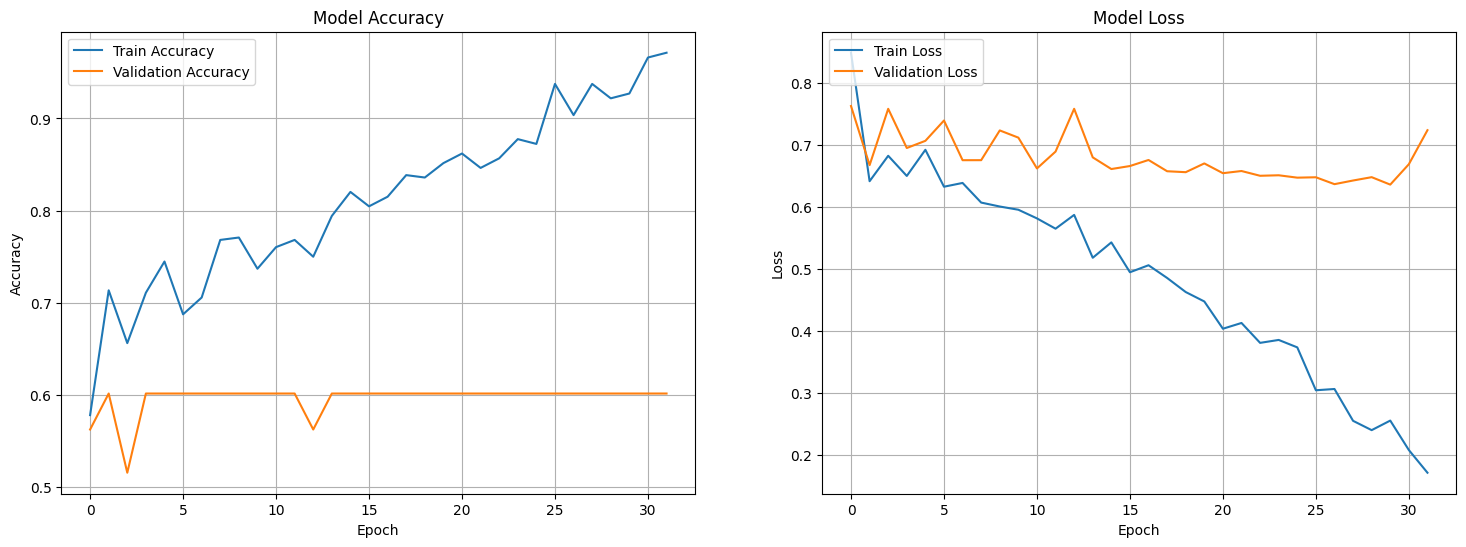


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.0000
Cohen's Kappa Score: 0.0000
AUC-ROC Score: 0.4469

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6023    1.0000    0.7518        53
    Abnormal     0.0000    0.0000    0.0000        35

    accuracy                         0.6023        88
   macro avg     0.3011    0.5000    0.3759        88
weighted avg     0.3627    0.6023    0.4528        88


Plotting Confusion Matrix...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


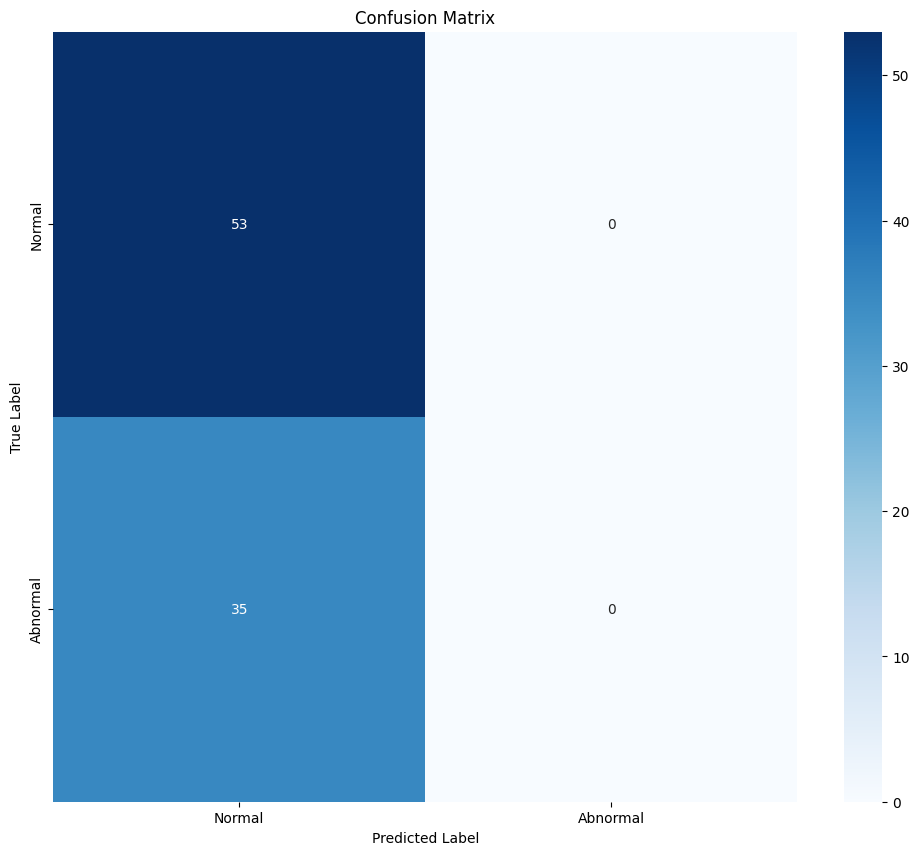


Plotting ROC Curves...


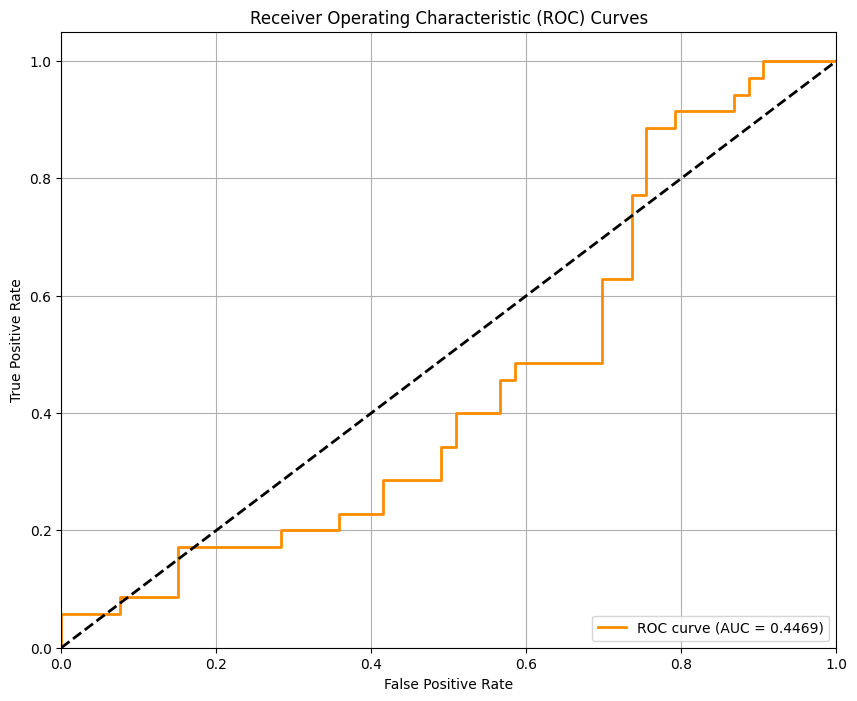

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed} # Still needed for the custom layer
)

# --- Creating dataset for evaluation ---
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_hybrid_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions on the finite validation set ---
print("Generating predictions on the validation set...")
predictions = best_model.predict(val_ds_eval)

# --- Getting true labels directly from the DataFrame ---
print("Extracting true labels...")
y_true = val_df['label'].values

# --- Processing predictions based on the task ---
if NUM_CLASSES == 2:
    # For binary classification, applying sigmoid to get probabilities
    y_prob = tf.nn.sigmoid(predictions).numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)
else:
    # For multi-class, softmax already gives probabilities
    y_prob = predictions
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")

# --- Matthews Correlation Coefficient and Cohen's Kappa ---
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

# --- AUC-ROC Scores ---
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    # Using One-vs-Rest for multi-class AUC
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    auc_roc_weighted = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")
    print(f"AUC-ROC (Weighted Average): {auc_roc_weighted:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
# Generating class names for the report if they exist
try:
    class_names = [name for name, index in sorted(class_to_id.items(), key=lambda item: item[1])]
except NameError:
    class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    # Binarizing the labels for multi-class ROC
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc:.4f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()